In [1]:
import os
import re
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import ssim
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import wandb
from tqdm import tqdm

In [2]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=1,
        depth=4,
        wf=3,
        padding=True,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [3]:
# Regular expression for numerical sorting
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Get device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Custom Dataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        label = Image.open(label_path).convert('L')  # Assuming ground truth labels are grayscale images

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

# Define transformations to apply to images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Directory paths
rendered = sorted(glob.glob(os.path.join(r'D:\CV_Project\results\integrals', '*.png')), key=numericalSort)

# Read and filter paths containing "GT" from CSV
df = pd.read_csv('dataset.csv')
paths = list(df['Path'])
label_paths = [path for path in paths if "GT" in os.path.basename(path)]

# Create dataset
dataset = CustomImageDataset(rendered, label_paths, transform=transform)

# DataLoader setup for batching and shuffling
batch_size = 2
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Output render count
print(f"Found {len(rendered)} renders!")


cuda
Found 32096 renders!


In [4]:
print(f"Number of rendered images: ", len(rendered))
print(f"Number of labeled images: ", len(label_paths))

Number of rendered images:  32096
Number of labeled images:  32096


In [5]:
# Output directory for saving images
save_path = r'D:\CV_Project\results\outputs'

def show_image(image_tensor):
    # Convert the image tensor to a NumPy array
    img_array = (np.transpose(image_tensor.detach().cpu().numpy(), (1, 2, 0)) * 255).astype(np.uint8)

    # Plot the image using Matplotlib
    plt.imshow(img_array, cmap='gray')  # Assuming it's a grayscale image
    plt.axis('off')  # Turn off axis labels    
    plt.show()

def save_image(image_tensor, name):
    # Convert the image tensor to a NumPy array
    img_array = image_tensor.squeeze().detach().cpu().numpy()  # Squeeze to remove single-dimensional entries

    # Plot the image using Matplotlib
    plt.imshow(img_array, cmap='gray')  # Assuming it's a grayscale image
    plt.axis('off')  # Turn off axis labels    

    # Save the image
    plt.savefig(os.path.join(save_path, name), bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to avoid displaying it

def show_input_output_target(input_image, output_image, target_image):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Creating a 1x3 grid for images

    images = [input_image, output_image, target_image]
    titles = ['Input', 'Output', 'Target']

    for ax, img, title in zip(axes, images, titles):
        img_array = img.detach().cpu().numpy()[0]
        ax.imshow(img_array, cmap='gray' if img.shape[0] == 1 else None)  # Assuming grayscale images
        ax.axis('off')  # Turn off axis labels
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [6]:
# Load pre-trained VGG model (e.g., VGG-16)
vgg = models.vgg16(pretrained=True).to(device)

# Freeze the weights to prevent updating during training
for param in vgg.parameters():
    param.requires_grad = False

# Extract features from intermediate layers
features = vgg.features  # Accessing the feature extraction layers

# Define a function to extract features from a specific layer
def get_features(image_tensor, layer_num):
    intermediate_model = nn.Sequential(*list(vgg.features.children())[:layer_num])
    return intermediate_model(image_tensor)

# Choose a layer to extract features from
layer_to_extract = 10  # Adjust this based on the layer you want to use

C:\Users\Woodquarter\miniconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Woodquarter\miniconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Parameters
learning_rate = 0.001
num_epochs = 200

# Initialize the model
model = UNet().to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Definethe ssim loss
def ssim_loss(output, target):
    return 1 - ssim(output, target, data_range=1.0)

In [8]:
# Initialize W&B
wandb.init(project='UNet', name='VPAT-01', entity='marceljulianhuber')

# Add model and hyperparameters
wandb.watch(model)
wandb.config.update(
    {
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'layer_to_extract': layer_to_extract,
    # 'loss': 'ssim + MSE (0.85)',
    'loss': 'VGG',

    # UNet parameters
    'in_channels': 1,
    'n_classes': 1,
    'depth': 5,
    'wf': 3,
    'padding': True,
    'batch_norm': False,
    'up_mode': 'upconv',
    })

wandb: Currently logged in as: marceljulianhuber. Use `wandb login --relogin` to force relogin


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

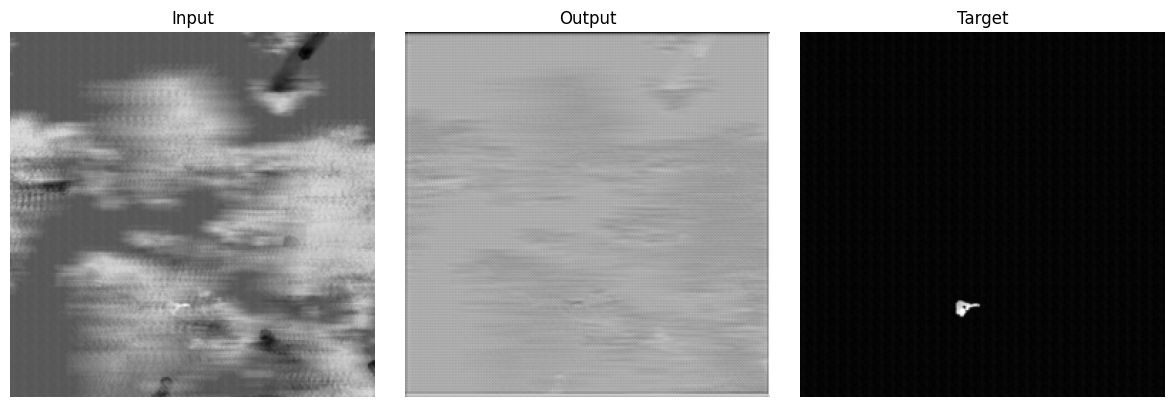

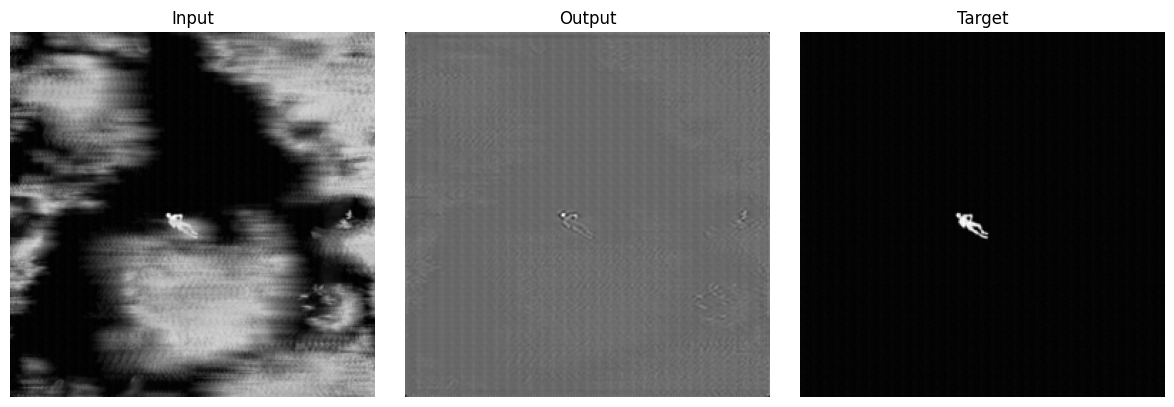

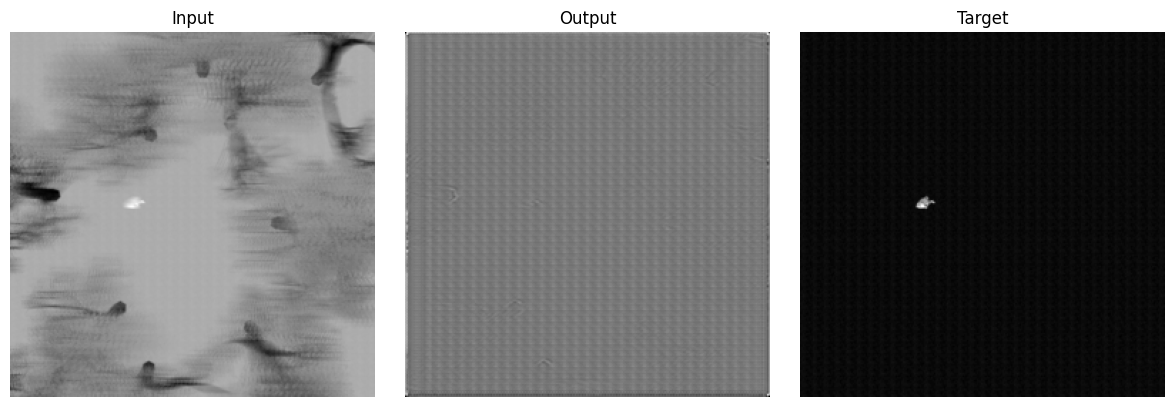

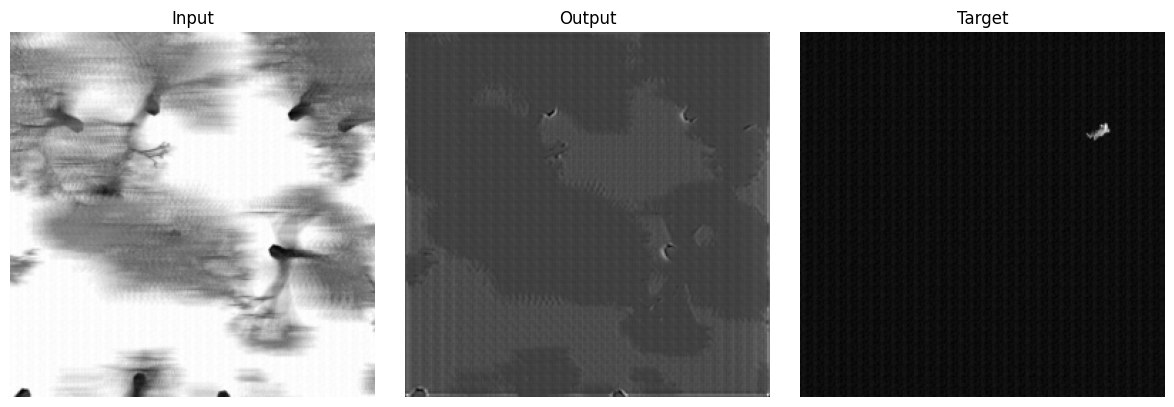

  0%|                                                                                          | 0/200 [18:25<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    counter = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # Move inputs to CUDA
        labels = labels.to(device)  # Move labels to CUDA
        
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.to(device)  # Move outputs to CUDA
        
        if counter % 1000 == 0:
            show_input_output_target(inputs[0], outputs[0], labels[0])

        ##################################################################################################################
        # Extract features from the generated and target images
        generated_features = get_features(outputs.repeat(1, 3, 1, 1), layer_to_extract).to(device)
        target_features = get_features(labels.repeat(1, 3, 1, 1), layer_to_extract).to(device)
        # Calculate the MSE loss between the features
        criterion = nn.MSELoss().to(device)
        loss = criterion(generated_features, target_features)
        ##################################################################################################################        
        # Calculate loss
        # mse_criterion = nn.MSELoss()
        # ssim_lambda = 0.85  # Weight for SSIM loss (adjust as needed)        
        # mse_loss = mse_criterion(outputs, labels)
        # ssim_loss_val = ssim_loss(outputs, labels)
        # loss = (mse_loss * (1 - ssim_lambda)) + (ssim_loss_val * ssim_lambda)
        ##################################################################################################################

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1

    # Calculate average loss per epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss}")

    # Log the average loss to W&B
    wandb.log({'Epoch': epoch+1, 'Loss': avg_loss})
    
    # Print average loss per epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader)}")

    # Save model every 5th epoch
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'VPAT_model_checkpoint_epoch_{epoch+1}.pth')

wandb.finish()  # Finish W&B run

In [ ]:
# torch.save(model.state_dict(), f'VPAT_model_checkpoint_00.pth')